In [0]:
import pandas as pd
import numpy as np
import os

folder_name = 'xxxxx'

In [0]:
# Applies wage indexation to hourly rates and gross incurred amounts, 
# df = data frame with claims data
# file = path to file with wage indices
# last_quarter_index = string with last quarter for which the index is available/used e.g. '2021Q4'
def wage_indexation(df, file):
    """
    Output: (Dataframe)
    dataframe with added columns with indexation factors and indexed wages and incurred amounts
    _____________________________________________________
    Parameters:
    df: (Dataframe) Dataframe with claims data
    file: (string) Path to the file with the wage index table
    """
    # Load dataset with wage indices
    wage_index_df = pd.read_excel(file)
    wage_index_df.columns = ['Date','Qrt','WA_index','TAS_index','ACT_index']
    wage_index_df = wage_index_df.sort_values(by='Date') # sort by date (earliest first)
    last_quarter = max(wage_index_df['Qrt'])
    # Complete missing quarters
    for y in range((min(pd.DatetimeIndex(wage_index_df['Date']).year)+1),(max(pd.DatetimeIndex(wage_index_df['Date']).year)+1)): # Iterate over all years in index data set
        for q in range(1,5): # Iterate over 4 quarters - Note this excludes 5
            if wage_index_df['Qrt'][wage_index_df['Qrt']==(str(y)+'Q'+str(q))].count() == 0: # if data doesn't exist for this quarter, take average of adjacent quarters
                i_below = wage_index_df[wage_index_df['Qrt'] == (str(y - (5-q) // 4) + 'Q' + str((q-2) % 4 + 1))].index[0]
                i_above = wage_index_df[wage_index_df['Qrt'] == (str(y + (q // 4)) + 'Q' + str(q % 4 + 1))].index[0]
                df2 = {'Date': np.datetime64((str(y) + '-0' + str((q-1)*3+2) + '-' + str(15) + 'T00:00:00.000')), 'Qrt': (str(y)+'Q'+str(q)), # Create row with new indexes
                       'WA_index': (wage_index_df['WA_index'][i_below] + wage_index_df['WA_index'][i_above])/2, 
                       'TAS_index' : (wage_index_df['TAS_index'][i_below] + wage_index_df['TAS_index'][i_above])/2, 
                       'ACT_index' : (wage_index_df['ACT_index'][i_below] + wage_index_df['ACT_index'][i_above])/2} 
                wage_index_df = wage_index_df.append(df2, ignore_index = True) # add extra row with average wage indices
    wage_index_df = wage_index_df.sort_values(by='Date')
    # Calculate index relative to last_period (currently 2021Q4)
    wage_index_df['WA'] = float(wage_index_df[wage_index_df['Qrt']==last_quarter]['WA_index'])/ wage_index_df['WA_index']
    wage_index_df['TAS'] = float(wage_index_df[wage_index_df['Qrt']==last_quarter]['TAS_index'])/ wage_index_df['TAS_index']
    wage_index_df['ACT'] = float(wage_index_df[wage_index_df['Qrt']==last_quarter]['ACT_index'])/ wage_index_df['ACT_index']
    # Convert dateframe to long format for easier merging
    wage_index_df_long = pd.melt(wage_index_df, id_vars='Qrt', value_vars=['WA','TAS','ACT']).rename(columns={'variable': 'Risk_State', 'value' : 'indexation_factor'})
    
    # Merge claim data set and indexation together by LossQuarter and Risk_State
    df['LossQuarter'] = pd.PeriodIndex(df['Claim_Loss_Date'], freq='Q').format()
    df['Claim_ID'] = range(1,len(df['Claim_Number'])+1)
    df = df.merge(wage_index_df_long, left_on=['LossQuarter','Risk_State'], right_on=['Qrt','Risk_State'], how='left')
    df['indexation_factor'] = df['indexation_factor'].fillna(1) # Periods after last available index are not indexed
    df['Gross_Incurred_Indexed'] = df['Gross_Incurred'] * df['indexation_factor'] # Index gross incurred amount
    df['Hourly_Rate_Indexed'] = df['Hourly_Rate_First_13_Weeks_v2'] * df['indexation_factor'] # Index hourly rate
    return df

# Converts dates in datetime format to number of years (numeric)
def convert_date_to_year(dates):
    return pd.DatetimeIndex(dates).year + (pd.DatetimeIndex(dates).month - 1)/12 + (pd.DatetimeIndex(dates).day-1)/365 # convert to numeric

# Converts dates to a usable numeric format (in years) and calculates differences (in years) for e.g. delays and durations
# df = data frame with claims data
def clean_dates(df):
    df['Claim_Loss_Date_Num'] =convert_date_to_year(df['Claim_Loss_Date'])
    df['Inception_Date_Claim_Num'] = convert_date_to_year(df['Inception_Date_Claim'])
    df['Inception_Date_Orig_Num'] = convert_date_to_year(df['Policy_Original_Inception_Date']) 
    df['Expiry_Date_Claim_Num'] =  convert_date_to_year(df['Expiry_Date_Claim'])
    df['Policy_Duration'] = df['Expiry_Date_Claim_Num'] - df['Inception_Date_Claim_Num'] # Policy_Duration is diff between expiry and inception date
    df['Time_Since_Orig_Policy_Inception'] = df['Claim_Loss_Date_Num'] - df['Inception_Date_Orig_Num']  # Time_Since_Orig_Policy_Inception is diff between loss date and original inception date
    df['Claim_Notified_Date_Num'] =  convert_date_to_year(df['Claim_Notified_Date'])
    df['Claim_Notified_Delay'] = df['Claim_Notified_Date_Num'] - df['Claim_Loss_Date_Num'] # Claim_Notified_Delay is diff between notified and loss date
    df['Liability_Date_Num'] =  convert_date_to_year(df['Liability_Date']) 
    df['Liability_Delay'] = df['Liability_Date_Num'] - df['Claim_Loss_Date_Num'] # Liability_Delay is diff between liability and loss date
    df['Worker_Age'] = df['Claim_Loss_Date_Num'] - convert_date_to_year(df['Worker_Birth_Date'])
    df['Work_Resumed_Date_Num'] = convert_date_to_year(df['Work_Resumed_Date'])
    df['Work_Resumed_Within_30days_Flag'] = ~df['Work_Resumed_Date'].isna() & ( (df['Work_Resumed_Date_Num'] - df['Claim_Loss_Date_Num'])  <(30/365) ) # Boolean indicating if work has been resumed within 30 days after the accident

    df['Worker_Weekly_Hours_Num'] =  pd.to_numeric(df['Worker_Weekly_Hours'].str.replace("h ", ".", regex=True).str.replace("m", "", regex=True)) # Convert weekly hours to numeric
    df['Worker_Weekly_Hours_Num'] = np.floor(df['Worker_Weekly_Hours_Num']) + (df['Worker_Weekly_Hours_Num'] - np.floor(df['Worker_Weekly_Hours_Num']) )/0.60 # Convert to decimal format (in hours)
    df['Weekly_Rate_First13_Indexed'] = df['indexation_factor'] * df['Hourly_Rate_First_13_Weeks_v2'] *  df['Worker_Weekly_Hours_Num'] # calculate weekly rate (note this is the indexed amount)
    df['Weekly_Rate_Thereafter_Indexed'] = df['indexation_factor'] * df['Hourly_Rate_Thereafter_v2']
    df['Weekly_Rate_Known'] = ~(df['Hourly_Rate_First_13_Weeks_v2'].isna()) & df['Hourly_Rate_First_13_Weeks_v2'] > 0.01 # Boolean flag indicating if weekly rate is known

    return (df)

# Detrends the gross incurred amounts by on-levelling historic claim amounts to a recent point in time
# df = data frame with claims data
# detrend_to = string with quarter to which claims are on-levelled e.g. '2021Q4'
# detrend_up_to = string wiht last quarter for which sufficiently developed claim amounts are available e.g. '2019Q4'
def detrend_incurred(df, onlevel_to_year, last_developed_year):
    # Calculate mean loss per year to determine trend (effectively a pivot table)
    trend = df.groupby('Claim_Loss_Year')['Gross_Incurred_Indexed'].mean()
    temp = trend.to_frame() # convert table to a dataframe
    temp['Loss_Year'] = trend.index # rename index to Loss_Year
    trend=temp
    trend['rate'] = (trend['Gross_Incurred_Indexed']/trend['Gross_Incurred_Indexed'].shift(periods=1)).fillna(1) # Calculate the relative increase in mean loss amount each year
    trend['arith_avg'] = (trend['rate'][trend['Loss_Year'] <= last_developed_year]).mean() # Calculate arithmetic average of relative increases each year, use only developed years
    trend['geom_avg'] = np.power((trend['rate'][trend['Loss_Year'] <= last_developed_year]).prod(),1/((trend['rate'][trend['Loss_Year'] <= last_developed_year]).size-1)) # Calculate geometric average of relative increases each year, use only developed years
    trend['power'] = range((trend['rate'][trend['Loss_Year'] < onlevel_to_year]).size-1,((trend['rate'][trend['Loss_Year'] < onlevel_to_year]).size-1)-trend['rate'].size,-1) # Get # of years between each loss year and the year to onlevel to
    trend['detrend_factor'] = trend['geom_avg'].pow(trend['power']) # Get detrend factor to apply to each year for on-levelling
    trend['detrended'] = trend['Gross_Incurred_Indexed'] * trend['detrend_factor'] # Apply onleveling factor to get on-leveled mean claim amounts
    print(trend) # Print resulting table
    # Merge table with detrend factors per year with the claims data set
    df = df.merge(trend[['Loss_Year','detrend_factor']], left_on='Claim_Loss_Year', right_on='Loss_Year', how='left')
    df['Gross_Incurred_Detrended'] = df['Gross_Incurred_Indexed'] * df['detrend_factor'] # Get onlevelled claim amounts for each individual claim
    return df



def calibrate_detrend_incurred(df, onlevel_to_year, last_developed_year, file_out):
    ''' Detrends the gross incurred amounts by on-levelling historic claim amounts to a recent point in time
    # df = data frame with claims data
    # onlevel_to_year = (int) year to which claims are on-levelled e.g. 2021
    # last_developed_year = (int) last year for which sufficiently developed claim amounts are available e.g. 2019
    file_out = (string) filename of csv where to save the detrend table
    '''
    # Calculate mean loss per year to determine trend (effectively a pivot table)
    trend = df.groupby('Claim_Loss_Year')['Gross_Incurred_Indexed'].mean()
    
    temp = trend.to_frame() # convert table to a dataframe
    temp['Loss_Year'] = trend.index # rename index to Loss_Year
    trend=temp
    max_year = max(trend['Loss_Year'])
    tmp = pd.DataFrame({'Loss_Year' : list(range(max_year+1, 2051)), 
                        'Gross_Incurred_Indexed': [1] * (2050-max_year)})
    trend = trend.append(tmp, ignore_index=True)
    trend['rate'] = (trend['Gross_Incurred_Indexed']/trend['Gross_Incurred_Indexed'].shift(periods=1)).fillna(1) # Calculate the relative increase in mean loss amount each year
    trend['arith_avg'] = (trend['rate'][trend['Loss_Year'] <= last_developed_year]).mean() # Calculate arithmetic average of relative increases each year, use only developed years
    trend['geom_avg'] = np.power((trend['rate'][trend['Loss_Year'] <= last_developed_year]).prod(),1/((trend['rate'][trend['Loss_Year'] <= last_developed_year]).size-1)) # Calculate geometric average of relative increases each year, use only developed years
    trend['power'] = range((trend['rate'][trend['Loss_Year'] <= onlevel_to_year]).size-1,((trend['rate'][trend['Loss_Year'] <= onlevel_to_year]).size-1)-trend['rate'].size,-1) # Get # of years between each loss year and the year to onlevel to
    trend['detrend_factor'] = trend['geom_avg'].pow(trend['power']) # Get detrend factor to apply to each year for on-levelling
    trend['detrended'] = trend['Gross_Incurred_Indexed'] * trend['detrend_factor'] # Apply onleveling factor to get on-leveled mean claim amounts
    print(trend) # Print resulting table
    trend.to_csv(file_out, index=False)
    print("Detrend table saved to "+file_out)
    return trend


def apply_detrend_incurred(df, detrend_file):
    trend = pd.read_csv(detrend_file)
    # Merge table with detrend factors per year with the claims data set
    df = df.merge(trend[['Loss_Year','detrend_factor']], left_on='Claim_Loss_Year', right_on='Loss_Year', how='left')
    df['Gross_Incurred_Detrended'] = df['Gross_Incurred_Indexed'] * df['detrend_factor'] # Get onlevelled claim amounts for each individual claim
    return df

# Looks at most common relevant words in the free text fields Cause_Of_Loss_Description and Injury_Most_Serious_Description, groups similar words. These have been selected manually using basic diagnostics.
# df = data frame with claims data
def free_text_fields_manual(df):
    df['Cause_Of_Loss_Description'] = df['Cause_Of_Loss_Description'].fillna("") # replace NaNs with blanks for easier text processing
    df['Injury_Most_Serious_Description'] = df['Injury_Most_Serious_Description'].fillna("") # replace NaNs with blanks for easier text processing
    df["free_text_fields"] = [str(s1) + ' ' + str(s2) for s1, s2 in zip( df['Cause_Of_Loss_Description'], df["Injury_Most_Serious_Description"] )] # Concatenate the two columns
    # Convert to lower case for each claim and check if it contains one of the selected keywords. A boolean flag is created for each keyword.
    df['strain'] = df["free_text_fields"].str.lower().str.contains("strain")
    df['laceration'] = df["free_text_fields"].str.lower().str.contains("lacerat")
    df['injury'] = df["free_text_fields"].str.lower().str.contains("injury")
    df['body'] = df["free_text_fields"].str.lower().str.contains("body")
    df['sprain'] = df["free_text_fields"].str.lower().str.contains("sprain")
    df['pain'] = df["free_text_fields"].str.lower().str.contains("pain")
    df['fracture'] = df["free_text_fields"].str.lower().str.contains("fracture") | df["free_text_fields"].str.lower().str.contains("fractrure")
    df['contusion'] = df["free_text_fields"].str.lower().str.contains("contusion")
    df['burn'] = df["free_text_fields"].str.lower().str.contains("burn")
    df['crush'] = df["free_text_fields"].str.lower().str.contains("crush")
    df['bruise'] = df["free_text_fields"].str.lower().str.contains("bruis")
    df['abrasion'] = df["free_text_fields"].str.lower().str.contains("abrasion")
    df['tear'] = df["free_text_fields"].str.lower().str.contains(" tear") | df["free_text_fields"].str.lower().str.contains(" torn")
    df['cut'] = df["free_text_fields"].str.lower().str.contains(" cut")
    df['wound'] = df["free_text_fields"].str.lower().str.contains("wound")
    df['bite'] = df["free_text_fields"].str.lower().str.contains("bite")
    df['anxiety'] = df["free_text_fields"].str.lower().str.contains("anxiety")
    df['broken'] = df["free_text_fields"].str.lower().str.contains("broken")
    df['puncture'] = df["free_text_fields"].str.lower().str.contains("puncture")
    df['shock'] = df["free_text_fields"].str.lower().str.contains("shock")
    df['whiplash'] = df["free_text_fields"].str.lower().str.contains("whiplash")
    df['fall'] = df["free_text_fields"].str.lower().str.contains(" fall") | df["free_text_fields"].str.lower().str.contains(" fell")
    df['amputation'] = df["free_text_fields"].str.lower().str.contains("amputat")
    return df

# Groups remaining fixed text fields so that similar classes are grouped, and classes with insufficient datapoints bundled i.e. Injury_Mechanism, Body_Location, Employee_Occupation, Claim_ANZSIC_2006, Occupation_Name
# df = data frame with claims data
def text_fields_groupings(df):
    # Injury_Mechanism
    temp = pd.read_csv('xxxx/Injury_Mechanism_Grouped.csv')
    df = df.merge(temp[['Injury_Mechanism','Injury_Mechanism_Grouped']], left_on='Injury_Mechanism', right_on='Injury_Mechanism', how='left') # Join with claims dataset
    
    # Body_Location
    temp = pd.read_csv('xxxx/Body_Location_Grouped.csv')
    df = df.merge(temp[['Body_Location','Body_Location_Grouped']], left_on='Body_Location', right_on='Body_Location', how='left') # Join with claims dataset
    
    # Employee_Occupation
    temp = pd.read_csv('xxxx/Employee_Occupation_Grouped.csv')
    df = df.merge(temp[['Employee_Occupation','Employee_Occupation_Grouped']], left_on='Employee_Occupation', right_on='Employee_Occupation', how='left')
    
    # Claim_ANZSIC_2006  
    temp = pd.read_csv('xxxx/Claim_ANZSIC_2006_Grouped.csv')
    df = df.merge(temp[['Claim_ANZSIC_2006','Claim_ANZSIC_2006_Grouped']], left_on='Claim_ANZSIC_2006', right_on='Claim_ANZSIC_2006', how='left')
    
    # Occupation_Name
    temp = pd.read_csv('xxxx/Occupation_Name_Grouped.csv')
    df = df.merge(temp[['Occupation_Name','Occupation_Name_Grouped']], left_on='Occupation_Name', right_on='Occupation_Name', how='left')
    return df

# Adds industry based on the industry code mapping
# df = data frame with claims data
# file = path to file with gross_incurreds at t30
def add_industry(df, file):
    df_IC = pd.read_excel(file, engine='pyxlsb') # Read industry code mapping
    temp = df_IC.iloc[1] # There are blank rows before the header, hence we save the header row and remove the blanks
    df_IC = df_IC.drop(df_IC.index[[0,1]]) # Remove first two rows
    df_IC = df_IC.drop_duplicates() # Remove duplicate rows
    df_IC.columns = temp # Set column headers
    df_IC.columns = df_IC.columns.str.replace(" ", "_", regex=True).str.replace("-", "_", regex=True) # Clean up header names
    df_IC =  df_IC.astype(str) # Make the entire dataframe consist of strings for eaiser industry code matching
    df_IC['Class_Description_'] = df_IC['Class_Description_'].str.lower() # Convert to lower case
    df_IC['Sub_division_Description'] = df_IC['Sub_division_Description'].str.lower()  # Convert to lower case
    df_IC['Class_Description_30'] = df_IC['Class_Description_'].str[:30]  # Take first 30 characters, since the Claim_ANZSIC_2006 field is truncated to 30 chars
    df['Employee_Occupation'] = df['Employee_Occupation'].str.lower() # Convert to lower case
    df['Claim_ANZSIC_2006'] = df['Claim_ANZSIC_2006'].str.lower() # Convert to lower case
    # Merge with claims data set based on Employee_Occupation, then on Claim_ANZSIC_2006
    df_claim_occup = df.merge(df_IC[['Class_Description_','Sub_division_Description']].drop_duplicates(), left_on='Employee_Occupation', right_on='Class_Description_', how='left')
    df_claim_occup = df_claim_occup.merge(df_IC[['Class_Description_30','Sub_division_Description']].drop_duplicates(['Class_Description_30']), left_on='Claim_ANZSIC_2006', right_on='Class_Description_30', how='left')
    df_claim_occup['Sub_div'] = df_claim_occup.iloc[:,-3] # Third last column is the Sub_divisin_description that we're looking for, based on join with key Employee_Occupation
    df_claim_occup.loc[df_claim_occup['Sub_div'].isna(),'Sub_div'] = df_claim_occup.iloc[(df_claim_occup['Sub_div'].isna()).values,-2] # If missing, take the Sub_divisin_description, based on join with key Claim_ANZSIC_2006
    df_claim_occup.loc[df_claim_occup['Sub_div']=='-','Sub_div'] = np.NaN
    df_claim_occup.loc[df_claim_occup['Sub_div'].isna(),'Sub_div'] = df_claim_occup.loc[df_claim_occup['Sub_div'].isna(),'Claim_ANZSIC_2006'] # If still missing take Claim_ANZIC_2006
    df_claim_occup.loc[df_claim_occup['Sub_div']=='-','Sub_div'] = np.NaN
    df_claim_occup.loc[df_claim_occup['Sub_div'].isna(),'Sub_div'] = df_claim_occup.loc[df_claim_occup['Sub_div'].isna(),'Employee_Occupation'] # If still missing take Employee_Occupation
    temp = pd.read_csv('/dbfs/mnt/augiprojects-20220225workerscomp/for sharing/data prep/Occupation_Grouped.csv')
    df_claim_occup = df_claim_occup.merge(temp[['Sub_div','Occupation_Grouped']].drop_duplicates(), left_on='Sub_div', right_on='Sub_div', how='left')
    df['Industry'] = df_claim_occup['Occupation_Grouped'] # Add column with grouped class to original dataframe
    return df 

# Adds incurred at t30
# df = data frame with claims data
# file = path to file with gross_incurreds at t30
def add_incurred_at_t30(df, file):
    df_incurred_t30 = pd.read_excel(file) # Read file with incurred amounts at t+30
    df['Claim_Number_C2'] =  'C2' + df['Claim_Number'].astype(str) # Add "C2" to claim numbers in data set to be able to map to t+30
    df = df.merge(df_incurred_t30, left_on='Claim_Number_C2', right_on='claimno', how='left') # join with claims data set
    df["incurred_t30_indexed"] = df['indexation_factor'] * df['detrend_factor'] * df['gross_incurred_t30'] # apply wage indexation and detrending
    return df

# Adds SEIFA code based on worker postcode
# df = data frame with claims data
# file = path to file with postcode/SEIFA mapping
def add_SEIFA(df, file):
    df_postcodes = pd.read_excel(file)
    df_postcodes = df_postcodes.rename(columns={"SEIFA_Advantaged_Disadvantaged_Rank":"SEIFA"})
    df_postcodes['Postcode'] = df_postcodes['Postcode'].astype(str)
    df_postcodes['SEIFA'] = df_postcodes['SEIFA'].astype(str)
    df['Worker_Postcode'] = df['Worker_Postcode'].astype(str)
    df = df.merge(df_postcodes[['Postcode','SEIFA']], left_on='Worker_Postcode', right_on='Postcode', how='left')
    df['P_SEIFA'] = 'P_' + df['SEIFA'].astype(str)
    return df
  
    
def residual_data_prep_python(df):
    """
    Output: (pandas DataFrame)
    Dataframe with certain fields cleaned or added
     _____________________________________________________
    Parameters:
    df: (pandas DataFrame) Dataframe with claims data to be cleaned
    """
    # copy (input not modified in place)
    df_processed_py = df.copy()

    # NA treatment (PYTHON SPECIFIC preprocessing)
    df_processed_py["Liability_Delay"] = df_processed_py["Liability_Delay"].fillna(0)
    df_processed_py["Worker_Gender"] = df_processed_py["Worker_Gender"].replace("-", "M")
    df_processed_py["Worker_Marital_Status"] = df_processed_py["Worker_Marital_Status"].replace("-", "S")
    df_processed_py["Full/Part_Time_Flag"] = df_processed_py["Full/Part_Time_Flag"].replace("-", "F")
    df_processed_py["Worker_Age"] = df_processed_py["Worker_Age"].fillna(df_processed_py["Worker_Age"].mean()) # IS THIS OK ?

    df_processed_py["SEIFA"] = df_processed_py["SEIFA"].fillna(-1) # -1 treated as NAN for LGBM

    # filter out newest dates (PYTHON SPECIFIC preprocessing) 
    #df_processed_py = df_processed_py[df_processed_py["Claim_Loss_Date"]<"2020"]

    # process the text data 

    # inputs and helper function for text processing 
    text_columns = ['Cause_Of_Loss_Description', 
                    'Agency_of_Accident', 
                    'Injury_Object_Involved', 
                    'Injury_Most_Serious_Description', 
                    'Injury_Nature', 
                    'Injury_Mechanism_Grouped']
    splt = [',', '/', '(', ')', '-', '&', "\'"]
    exclude = ['AND', 'IN', 'TO', 'OF', 'OFF', 'ON', "BY"]

    def clean_str(st, split_, excl):
        """
        Output: (string)
        st with removed words in excl, separators in split_
        _____________________________________________________
        Parameters:
        st: (string) string of words to be processed
        split_: (list) characters to be considered separators 
        excl: (list) words to be removed from string
        """
        st = str(st)
        for a in split_:
            st = st.replace(a, ' ')
        l = [s for s in st.split() if not s in excl or (len(s) == 1 and not s.isalpha())]
        return " ".join(l)

    # text processing

    # remove NA from Duty_Status
    df_processed_py.loc[df_processed_py["Duty_Status"].isnull(), "Duty_Status"] = 1

    # fill NA
    df_processed_py["incurred_t30_indexed"].fillna(-9999, inplace=True)

    # treat NA as empty characters in the text columns
    df_processed_py[text_columns] = df_processed_py[text_columns].fillna("")

    # concatenate text fields into one column
    text_fields_vector = zip(*[df_processed_py[col] for col in text_columns])
    df_processed_py["concatenated_text"] = ["".join(str(v)) for v in text_fields_vector]

    # clean concatenated text with helper function
    df_processed_py["concatenated_text"] = df_processed_py["concatenated_text"].apply(lambda x: clean_str(x, splt, exclude))


    # convert categorical features to int for training
    categorical_features = ["Liability_Status_Grouped",  
                            "Worker_Gender", 
                            "Worker_Marital_Status", 
                            "Risk_State", 
                            "Full/Part_Time_Flag", 
                            "Injury_Mechanism_Grouped",
                            "Body_Location_Grouped", 
                            "Industry", 
                            "Occupation_Name_Grouped", 
                            "Claim_ANZSIC_2006_Grouped", 
                            "Employee_Occupation_Grouped", 
                            "IMA_Reviewed_Flag", 
                            "Weekly_Rate_Known",
                            "Work_Resumed_Within_30days_Flag"]

    def cat_to_int(col):
        """
        Output: (pandas Series)
        column of int corresponding to category mapping
        _____________________________________________________
        Parameters:
        col: (pandas Series) categorical variable column
        """
        unique_val = np.unique(col.to_numpy())
        d = {unique_val[i]:i for i in range(len(unique_val))}
        return col.apply(lambda x: d[x])

    # turn categorical variable into categorical int  
    for cat_f in categorical_features:
        df_processed_py[cat_f] = cat_to_int(df_processed_py[cat_f].astype(str))

    # convert boolean to int 
    df_processed_py = df_processed_py.replace([True, False], [1, 0])
    return df_processed_py

In [0]:
def prepare_dataset(path_to_data = folder_name + 'unlabelled_data.csv',
                    path_to_wage_index = folder_name + 'Wage Price Index 2021Q4.xlsx',
                    path_to_detrending_factors = folder_name + 'detrend.csv',
                    path_to_industry_codes = folder_name + 'WorkCover-WA-Industry-Codes-for-Recommended-Premium-Rates.xlsb',
                    path_to_incurred_at_t30 = folder_name + 'Incurred_at_T30.xlsx',
                    path_to_SEIFA_codes = folder_name + '2016 Census Fields by Postcode.xlsx',
                    path_to_output = folder_name + 'unlabelled_data_prepped.csv'):
    """
    Output: (pandas DataFrame)
    Dataframe with added columns contained cleaned/enhanced data
    _____________________________________________________
    Parameters:
    path_to_data: (string) path to csv or xlsx file with claims data
    path_to_wage_index: (string) path to csv or xlsx file with claims data
    path_to_detrending_factors: (string) path to csv file with detrending factors as generated by update_detrend_incurred()
    path_to_industry_codes: (string) path to xlsb file with industry code mapping
    path_to_incurred_at_t30: (string) path to xlsx file with incurred amounts at t30 per claim
    path_to_SEIFA_codes: (string) path xlsx file with postcode to SEIFA mapping
    path_to_output: (string) path to csv where output will be stored
    """
    # Read file
    temp, file_extension = os.path.splitext(path_to_data)
    #print("File extension: " + file_extension)
    if(file_extension == '.xlsx'):
        #print('Excel file')
        df_claim = pd.read_excel(path_to_data)
    else: # assume csv
        #print('CSV file')
        df_claim = pd.read_csv(path_to_data, low_memory=False)
        
    # Replace brackets and spaces in columns names by underscore
    df_claim.columns = df_claim.columns.str.replace("[ ]", "_", regex=True)
    df_claim.columns = df_claim.columns.str.replace("[()]", "", regex=True)
 
    # Index wages and losses using wage index data set
    df_claim = wage_indexation(df = df_claim, file=path_to_wage_index)
    # Convert dates and calculate relevant time differences / delays, also convert wages to weekly rates
    df_claim = clean_dates(df = df_claim)
  
    # Detrend gross incurred losses (assume exponential growth) by on-leveling to a recent point in time
    #calibrate_detrend_incurred(df_claim, 2021, 2019, path_to_detrending_factors)
    df_claim = apply_detrend_incurred(df_claim, path_to_detrending_factors)
 
    ### Categorical variable preparation ###    
    # Liability status - create bucket '-' for missing data and rare classes
    df_claim['Liability_Status_Grouped'] = df_claim['Liability_Status']
    df_claim.loc[~ df_claim['Liability_Status'].isin(['A','D','P','V','W','I']), 'Liability_Status_Grouped'] = "-"

    # Cause_Of_Loss_Description & Injury_Most_Serious_Description - Free text field analysis - extract most common revelant words
    df_claim = free_text_fields_manual(df=df_claim)

    # Individual categorical variables - Injury_Mechanism, Body_Location, ... => group similar classes and create bucket for missing data and rare classes (<100 occurrences)
    df_claim = text_fields_groupings(df=df_claim)
    
    # Map occupation to industry
    df_claim = add_industry(df=df_claim, file = path_to_industry_codes)

    # Add gross incurred at t+30 where available + onlevel
    df_claim = add_incurred_at_t30(df=df_claim, file = path_to_incurred_at_t30)

    # Add SEIFA to postcodes
    df_claim = add_SEIFA(df=df_claim, file = path_to_SEIFA_codes)    
    df_claim = df_claim.sort_values(by="Claim_Loss_Date_Num").reset_index(drop=True)
    #print(df_claim.head(100))
    
    # Residual data preparation, mostly filtering out blanks
    df_claim = residual_data_prep_python(df_claim)

    # Save new data set as CSV
    df_claim.to_csv(path_to_output, index=False)
        
    return df_claim


# Test run
df = prepare_dataset(path_to_data = folder_name + 'Claim Severity Model Data - 20220525.xlsx',
               path_to_wage_index = folder_name + 'Wage Price Index 2021Q4.xlsx',
               path_to_detrending_factors = folder_name + 'detrend.csv',
               path_to_industry_codes = folder_name + 'WorkCover-WA-Industry-Codes-for-Recommended-Premium-Rates.xlsb',
               path_to_incurred_at_t30 = folder_name + 'Incurred_at_T30.xlsx',
               path_to_SEIFA_codes = folder_name + '2016 Census Fields by Postcode.xlsx',
               path_to_output = folder_name + 'unlabelled_data_prepped.csv')


---------------------------------------------------------------------------
FileNotFoundError                         Traceback (most recent call last)
<command-3647493134882365> in <cell line: 76>()
     74 
     75 # Test run
---> 76 df = prepare_dataset(path_to_data = folder_name + 'Claim Severity Model Data - 20220525.xlsx',
     77                path_to_wage_index = folder_name + 'Wage Price Index 2021Q4.xlsx',
     78                path_to_detrending_factors = folder_name + 'detrend.csv',

<command-3647493134882365> in prepare_dataset(path_to_data, path_to_wage_index, path_to_detrending_factors, path_to_industry_codes, path_to_incurred_at_t30, path_to_SEIFA_codes, path_to_output)
     24     if(file_extension == '.xlsx'):
     25         #print('Excel file')
---> 26         df_claim = pd.read_excel(path_to_data)
     27     else: # assume csv
     28         #print('CSV file')

/databricks/python/lib/python3.9/site-packages/pandas/util/_decorators.py in wrapper(*args, **kwargs)

38171
38171
28300.404620359594
-9999.0
0.5063791883890912
27135.427378828852
19178 20362.187884
Name: incurred_t30_indexed, dtype: float64
33278 1213.943668
Name: incurred_t30_indexed, dtype: float64
1 -9999.0
Name: incurred_t30_indexed, dtype: float64
Out[21]:

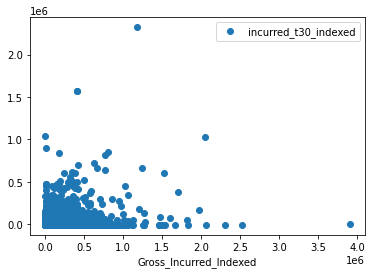

<AxesSubplot:xlabel='Gross_Incurred_Indexed'>

In [0]:
##############
#### REMOVE ##
##############
# Diagnostics 
print(len(df))
print(len(df[~df['Gross_Incurred_Indexed'].isnull()]))
print(df['incurred_t30_indexed'][df['incurred_t30_indexed']>0].mean())
print(df['incurred_t30_indexed'][df['incurred_t30_indexed']<0].mean())
print(len(df['incurred_t30_indexed'][df['incurred_t30_indexed']<0])/ len(df))
print(df['Gross_Incurred_Indexed'].mean())
print(df['incurred_t30_indexed'][df['Claim_Number']=='3192885'])
print(df['incurred_t30_indexed'][df['Claim_Number']=='3589074'])
print(df['incurred_t30_indexed'][df['Claim_Number']=='2841418'])
df.plot('Gross_Incurred_Indexed', 'incurred_t30_indexed', style='o')
# df.to_csv(folder_name +'reference_preprocess_data_2408.csv')

In [0]:
 # To recalibrate the detrending on a given dataset:
def update_detrend_incurred(path_to_data = folder_name + 'Claim Severity Model Data - 20220525.xlsx',
                              path_to_wage_index = folder_name + 'Wage Price Index 2021Q4.xlsx',
                              path_to_detrending_factors = folder_name + 'detrend_update.csv',
                              max_developed_year = 2019,
                              year_to_onlevel_to = 2021):  
                           
    # Read file
    temp, file_extension = os.path.splitext(path_to_data)
    if(file_extension == '.xlsx'):
        df_claim = pd.read_excel(path_to_data)
    else: # assume csv
         df_claim = pd.read_csv(path_to_data)
    # Replace brackets and spaces in columns names by underscore
    df_claim.columns = df_claim.columns.str.replace("[ ]", "_", regex=True)
    df_claim.columns = df_claim.columns.str.replace("[()]", "", regex=True)

    # Index wages and losses using wage index data set
    df_claim = wage_indexation(df = df_claim, file=path_to_wage_index)
    # Convert dates and calculate relevant time differences / delays, also convert wages to weekly rates
    df_claim = clean_dates(df = df_claim)
    trend = calibrate_detrend_incurred(df_claim, year_to_onlevel_to, max_developed_year, path_to_detrending_factors)
    return trend

In [0]:

# Groups remaining fixed text fields so that similar classes are grouped, and classes with insufficient datapoints bundled i.e. Injury_Mechanism, Body_Location, Employee_Occupation, Claim_ANZSIC_2006, Occupation_Name
# df = data frame with claims data
def text_fields_groupings_train(df):
    # Injury_Mechanism
    temp = df.groupby('Injury_Mechanism',as_index=False)["Claim_Number"].count()
    temp['Injury_Mechanism_Grouped'] = temp['Injury_Mechanism'] 
    temp.loc[temp['Injury_Mechanism'].isin(['HITTING STATIONARY OBJECTS','HITTING MOVING OBJECTS','BEING HIT BY MOVING OBJECTS']),'Injury_Mechanism_Grouped'] = 'HIT OBJECT' # Group these as they have similar loss profile and are semantically similar
    temp.loc[temp['Injury_Mechanism'].isin(['MUSCULAR STRESS WHILE HANDLING OBJECTS OTHER THAN LIFTING, CARRYING OR PUTTING DOWN','MUSCULAR STRESS WHILE LIFTING, CARRYING OR PUTTING DOWN OBJECTS']),'Injury_Mechanism_Grouped'] = 'MUSCULAR STRESS' # Group these as they have similar loss profile and are semantically similar
    temp.loc[temp['Claim_Number'] < 210,'Injury_Mechanism_Grouped'] = 'OTHER' # Group all classes with insufficient datapoints
    temp.to_csv('/dbfs/mnt/augiprojects-20220225workerscomp/for sharing/data prep/Injury_Mechanism_Grouped.csv', index=False)
    df = df.merge(temp[['Injury_Mechanism','Injury_Mechanism_Grouped']], left_on='Injury_Mechanism', right_on='Injury_Mechanism', how='left') # Join with claims dataset
    
    # Body_Location
    temp = df.groupby('Body_Location',as_index=False)["Claim_Number"].count()
    temp['Body_Location_Grouped'] = temp['Body_Location']   
    temp.loc[temp['Body_Location'].isin(['EYE - UNSPECIFIED','EYEBALL','EYE - OTHER AND MULTIPLE']),'Body_Location_Grouped'] = 'EYE' # Group these as they have similar loss profile and are semantically similar
    temp.loc[temp['Body_Location'].isin(['FINGERS','HAND','THUMB','HAND, FINGERS AND THUMB - OTHER AND MULTIPLE']),'Body_Location_Grouped'] = 'HAND'
    temp.loc[temp['Body_Location'].isin(['HEAD - UNSPECIFIED LOCATIONS','CRANIUM','FACE','EAR']),'Body_Location_Grouped'] = 'HEAD'
    temp.loc[temp['Body_Location'].isin(['NECK AND SHOULDER','NECK - OTHER AND MULTIPLE']),'Body_Location_Grouped'] = 'NECK - MULTIPLE'
    temp.loc[temp['Body_Location'].isin(['FOOT','LOWER LEG','TOES']),'Body_Location_Grouped'] = 'FOOT'
    temp.loc[temp['Claim_Number'] < 200,'Body_Location_Grouped'] = 'OTHER' # Group all classes with insufficient datapoints
    temp.to_csv('/dbfs/mnt/augiprojects-20220225workerscomp/for sharing/data prep/Body_Location_Grouped.csv', index=False)
    df = df.merge(temp[['Body_Location','Body_Location_Grouped']], left_on='Body_Location', right_on='Body_Location', how='left') # Join with claims dataset
    
    # Employee_Occupation
    temp = df.groupby('Employee_Occupation',as_index=False)["Claim_Number"].count()
    temp['Employee_Occupation_Grouped'] = temp['Employee_Occupation'] 
    temp.loc[temp['Claim_Number'] < 100,'Employee_Occupation_Grouped'] = 'OTHER' # Group all classes with insufficient datapoints
    temp.to_csv('/dbfs/mnt/augiprojects-20220225workerscomp/for sharing/data prep/Employee_Occupation_Grouped.csv', index=False)
    df = df.merge(temp[['Employee_Occupation','Employee_Occupation_Grouped']], left_on='Employee_Occupation', right_on='Employee_Occupation', how='left')
    
    # Claim_ANZSIC_2006
    temp = df.groupby('Claim_ANZSIC_2006',as_index=False)["Claim_Number"].count()
    temp['Claim_ANZSIC_2006_Grouped'] = temp['Claim_ANZSIC_2006']
    temp.loc[temp['Claim_Number'] < 100,'Claim_ANZSIC_2006_Grouped'] = 'OTHER' # Group all classes with insufficient datapoints
    temp.to_csv('/dbfs/mnt/augiprojects-20220225workerscomp/for sharing/data prep/Claim_ANZSIC_2006_Grouped.csv', index=False)
    df = df.merge(temp[['Claim_ANZSIC_2006','Claim_ANZSIC_2006_Grouped']], left_on='Claim_ANZSIC_2006', right_on='Claim_ANZSIC_2006', how='left')
    
    # Occupation_Name
    temp = df.groupby('Occupation_Name',as_index=False)["Claim_Number"].count()
    temp['Occupation_Name_Grouped'] = temp['Occupation_Name'] 
    temp.loc[temp['Claim_Number'] < 100,'Occupation_Name_Grouped'] = 'OTHER' # Group all classes with insufficient datapoints
    temp.to_csv('/dbfs/mnt/augiprojects-20220225workerscomp/for sharing/data prep/Occupation_Name_Grouped.csv', index=False)
    df = df.merge(temp[['Occupation_Name','Occupation_Name_Grouped']], left_on='Occupation_Name', right_on='Occupation_Name', how='left')
    return df


# Adds industry based on the industry code mapping
# df = data frame with claims data
# file = path to file with gross_incurreds at t30
def add_industry_train(df, file):
    df_IC = pd.read_excel(file, engine='pyxlsb') # Read industry code mapping
    temp = df_IC.iloc[1] # There are blank rows before the header, hence we save the header row and remove the blanks
    df_IC = df_IC.drop(df_IC.index[[0,1]]) # Remove first two rows
    df_IC = df_IC.drop_duplicates() # Remove duplicate rows
    df_IC.columns = temp # Set column headers
    df_IC.columns = df_IC.columns.str.replace(" ", "_", regex=True).str.replace("-", "_", regex=True) # Clean up header names
    df_IC =  df_IC.astype(str) # Make the entire dataframe consist of strings for eaiser industry code matching
    df_IC['Class_Description_'] = df_IC['Class_Description_'].str.lower() # Convert to lower case
    df_IC['Sub_division_Description'] = df_IC['Sub_division_Description'].str.lower()  # Convert to lower case
    df_IC['Class_Description_30'] = df_IC['Class_Description_'].str[:30]  # Take first 30 characters, since the Claim_ANZSIC_2006 field is truncated to 30 chars
    df['Employee_Occupation'] = df['Employee_Occupation'].str.lower() # Convert to lower case
    df['Claim_ANZSIC_2006'] = df['Claim_ANZSIC_2006'].str.lower() # Convert to lower case
    # Merge with claims data set based on Employee_Occupation, then on Claim_ANZSIC_2006
    df_claim_occup = df.merge(df_IC[['Class_Description_','Sub_division_Description']].drop_duplicates(), left_on='Employee_Occupation', right_on='Class_Description_', how='left')
    df_claim_occup = df_claim_occup.merge(df_IC[['Class_Description_30','Sub_division_Description']].drop_duplicates(['Class_Description_30']), left_on='Claim_ANZSIC_2006', right_on='Class_Description_30', how='left')
    df_claim_occup['Sub_div'] = df_claim_occup.iloc[:,-3] # Third last column is the Sub_divisin_description that we're looking for, based on join with key Employee_Occupation
    df_claim_occup.loc[df_claim_occup['Sub_div'].isna(),'Sub_div'] = df_claim_occup.iloc[(df_claim_occup['Sub_div'].isna()).values,-2] # If missing, take the Sub_divisin_description, based on join with key Claim_ANZSIC_2006
    df_claim_occup.loc[df_claim_occup['Sub_div']=='-','Sub_div'] = np.NaN
    df_claim_occup.loc[df_claim_occup['Sub_div'].isna(),'Sub_div'] = df_claim_occup.loc[df_claim_occup['Sub_div'].isna(),'Claim_ANZSIC_2006'] # If still missing take Claim_ANZIC_2006
    df_claim_occup.loc[df_claim_occup['Sub_div']=='-','Sub_div'] = np.NaN
    df_claim_occup.loc[df_claim_occup['Sub_div'].isna(),'Sub_div'] = df_claim_occup.loc[df_claim_occup['Sub_div'].isna(),'Employee_Occupation'] # If still missing take Employee_Occupation
    # Pivot table to check how often each class appears
    temp = df_claim_occup.groupby('Sub_div',as_index=False)["Claim_Number"].count()
    temp['Occupation_Grouped'] = temp['Sub_div'] 
    temp.loc[temp['Claim_Number'] < 50,'Occupation_Grouped'] = 'OTHER' # Group all classes with insufficient data points
    temp.to_csv('xxxx/Occupation_Grouped.csv', index=False)
    df_claim_occup = df_claim_occup.merge(temp[['Sub_div','Occupation_Grouped']].drop_duplicates(), left_on='Sub_div', right_on='Sub_div', how='left')
    df['Industry'] = df_claim_occup['Occupation_Grouped'] # Add column with grouped class to original dataframe
    return df 

## Example run to update groupings
#df_claim = pd.read_excel('/dbfs/mnt/augiprojects-20220225workerscomp/for sharing/Claim Severity Model Data - 20220525.xlsx')
#df_claim.columns = df_claim.columns.str.replace("[ ]", "_", regex=True)
#df_claim.columns = df_claim.columns.str.replace("[()]", "", regex=True)
#text_fields_groupings_train(df_claim)
#add_industry_train(df_claim, '/dbfs/mnt/augiprojects-20220225workerscomp/for sharing/WorkCover-WA-Industry-Codes-for-Recommended-Premium-Rates.xlsb')